In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
%cd D:/data/netflix

D:\data\netflix


In [3]:
%ls

 Volume in drive D is New Volume
 Volume Serial Number is 0676-C2E1

 Directory of D:\data\netflix

09/02/2022  03:57 PM    <DIR>          .
09/02/2022  03:57 PM    <DIR>          ..
11/13/2019  06:40 PM       495,032,008 combined_data_1.txt
11/13/2019  06:41 PM       555,207,357 combined_data_2.txt
11/13/2019  06:42 PM       465,157,779 combined_data_3.txt
11/13/2019  06:42 PM       552,537,802 combined_data_4.txt
08/30/2022  11:02 PM     2,711,021,172 data.csv
11/13/2019  06:43 PM           577,547 movie_titles.csv
09/02/2022  04:11 PM       586,074,331 netflix_data.parquet
11/13/2019  06:43 PM        10,782,692 probe.txt
11/13/2019  06:43 PM        52,452,386 qualifying.txt
11/13/2019  06:40 PM             5,916 README
              10 File(s)  5,428,848,990 bytes
               2 Dir(s)  383,254,777,856 bytes free


In [13]:
# DataFrame to store all imported data
files = ['combined_data_1.txt',
        'combined_data_2.txt',
        'combined_data_3.txt',
        'combined_data_4.txt'
        ]
        
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()

Opening file: combined_data_1.txt
Opening file: combined_data_2.txt
Opening file: combined_data_3.txt
Opening file: combined_data_4.txt


In [7]:
# Reading movie titles
# Read all data into a pd dataframe
df = pd.read_csv('data.csv', names=['movie_id', 'user_id','rating','date'])
print(df.nunique())
df.head()

movie_id     17770
user_id     480189
rating           5
date          2182
dtype: int64


,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [8]:
# function to decrease data size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
# Reduce memory usage
df = reduce_mem_usage(df)
df.head()

Mem. usage decreased to 1437.39 Mb (53.1% reduction)


,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


### Why converting data to parquet format ?
<ul>
    <li> parquet is coulmnar formate which will decrease the memory usage when quering the data because we will not scan all the data like row based formats</li>
    <li> splitable</li>
    <li> compressable</li>
</ul>

In [10]:
# convert row based data to columnar parquet format
df.to_parquet('netflix_data.parquet')

In [9]:
# compare size of the csv to the parquet file
print('csv size: ', os.path.getsize('data.csv')/1024**2, 'MB')
print('parquet size: ', os.path.getsize('netflix_data.parquet')/1024**2, 'MB')
print('compression ratio: ', os.path.getsize('data.csv')/os.path.getsize('netflix_data.parquet'))


csv size:  2585.4312629699707 MB
parquet size:  558.9240369796753 MB
compression ratio:  4.6257292438900555


In [4]:
# read parquet file
df = pd.read_parquet('netflix_data.parquet')
df.head()

,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [5]:
#data types
df.dtypes

movie_id     int16
user_id      int32
rating        int8
date        object
dtype: object

In [6]:
df.describe()

,movie_id,user_id,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


In [7]:
df.shape

(100480507, 4)

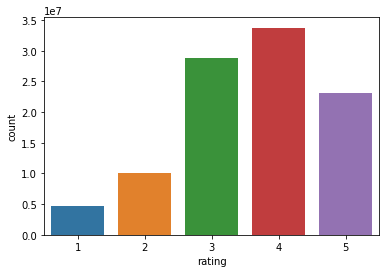

In [8]:
# Visualize data
sns.countplot(x='rating', data=df)
plt.show()

In [9]:
# Group by movie id and get the average rating
movie_ratings = df.groupby('movie_id').mean()
movie_ratings.drop('user_id', axis=1, inplace=True)
movie_ratings.head()

,rating
movie_id,
1,3.749543
2,3.558621
3,3.641153
4,2.739437
5,3.919298


c:\Users\CompuMisr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


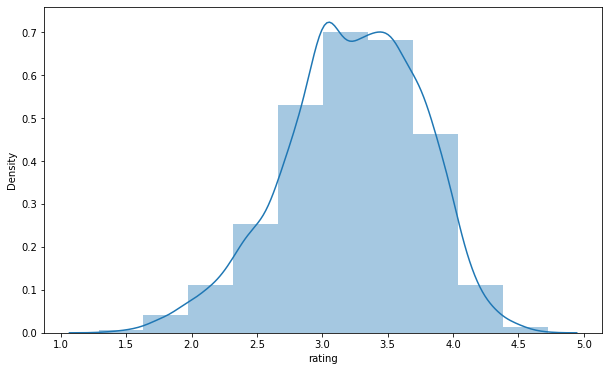

In [10]:
# plot the average rating for each movie
plt.figure(figsize=(10,6))
sns.distplot(movie_ratings['rating'], bins=10)
plt.show()


In [11]:
movie_title = pd.read_csv('movie_titles.csv',
                          encoding = 'ISO-8859-1',
                        usecols=[0,1,2], 
                          names = ['movie_id', 'year', 'name'])

movie_title.head()

,movie_id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [12]:
# movie_title year null values
movie_title['year'].isnull().sum()

7

In [13]:
# fill null values with mode value
movie_title['year'].fillna(movie_title['year'].mode()[0], inplace=True)

In [14]:
# Convert year to int
movie_title['year'] = movie_title['year'].astype(int)

In [15]:
# year and name of the movie
movie_ratings = pd.merge(movie_ratings, movie_title, left_index=True, right_index=True)
movie_ratings.head()

,rating,movie_id,year,name
1,3.749543,2,2004,Isle of Man TT 2004 Review
2,3.558621,3,1997,Character
3,3.641153,4,1994,Paula Abdul's Get Up & Dance
4,2.739437,5,2004,The Rise and Fall of ECW
5,3.919298,6,1997,Sick


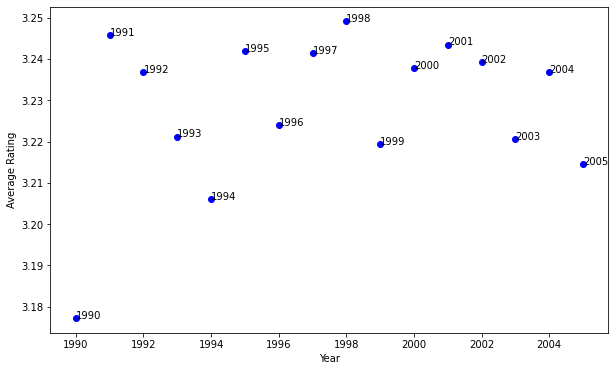

In [16]:
# plot each year and the average rating
plt.figure(figsize=(10,6))
for i in range(1990, 2011):
    plt.scatter(i, movie_ratings[movie_ratings['year']==i]['rating'].mean(), color='b')
    plt.annotate(i, (i, movie_ratings[movie_ratings['year']==i]['rating'].mean()))
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

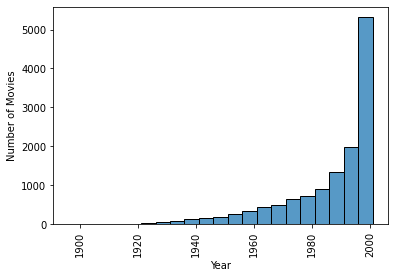

In [17]:
# visualize the data
bins =range(movie_ratings['year'].min(), movie_ratings['year'].max(), 5)
sns.histplot(x='year', data=movie_ratings, bins=bins)
# rotate the x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of Movies')

plt.show()

In [18]:
# create a new dataframe with movie id and name
movie_df = movie_ratings[['name', 'year']]
movie_df.head()


,name,year
1,Isle of Man TT 2004 Review,2004
2,Character,1997
3,Paula Abdul's Get Up & Dance,1994
4,The Rise and Fall of ECW,2004
5,Sick,1997


In [19]:
df.shape

(100480507, 4)

In [20]:
movie_df.shape

(17769, 2)

## Collaborative Filtering recommendation system

<p>Now it's time to start our work on recommendation systems.</p>
<p>The first technique we're going to take a look at is called <strong>Collaborative Filtering</strong>, which is also known as <strong>User-User Filtering</strong>. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the <strong>Pearson Correlation Function</strong>.</p>
<img width="800px" src="https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs11227-020-03266-2/MediaObjects/11227_2020_3266_Fig1_HTML.png?as=webp">

<p>The process for creating a User Based recommendation system is as follows:</p>
<ul>
<li>Select a user with the movies the user has watched</li>
<li>Based on his rating of the movies, find the top X neighbours</li>
<li>Get the watched movie record of the user for each neighbour</li>
<li>Calculate a similarity score using some formula</li>
<li>Recommend the items with the highest score</li>
</ul>
<p>Let's begin by creating an input user to recommend movies to:</p>
<p>Notice: To add more movies, simply increase the amount of elements in the userInput. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The' .</p>

In [21]:
user_input = [
            {'name':'The Breakfast Club', 'rating':5},
            {'name':'Toy Story', 'rating':3.5},
            {'name':'Jumanji', 'rating':2},
            {'name':"Pulp Fiction", 'rating':5},
            {'name':'Akira', 'rating':4.5}
         ] 
input_movies = pd.DataFrame(user_input)
input_movies.head()

,name,rating
0,The Breakfast Club,5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


In [22]:
# add movie id to input movie
input_id = movie_title[movie_title['name'].isin(input_movies['name'].tolist())]

# add movie id to input movie
input_movies = pd.merge(input_id, input_movies)
input_movies

,movie_id,year,name,rating
0,6797,1985,The Breakfast Club,5.0
1,10662,1988,Akira,4.5
2,11064,1994,Pulp Fiction,5.0
3,13673,1995,Toy Story,3.5
4,15078,1995,Jumanji,2.0


In [23]:
##Filtering out users that have watched movies that the input has watched and storing it
user_subset = df[df['movie_id'].isin(input_movies['movie_id'].tolist())]
user_subset.head()

,movie_id,user_id,rating,date
38097698,6797,445672,5,2005-07-05
38097699,6797,1734805,3,2000-09-09
38097700,6797,1392773,4,2001-05-30
38097701,6797,716091,5,2000-01-08
38097702,6797,828567,5,2005-07-07


In [24]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
user_subset_group = user_subset.groupby(['user_id'])

In [25]:
# Getting user 445672's ratings
user_subset_group.get_group(445672)

,movie_id,user_id,rating,date
38097698,6797,445672,5,2005-07-05
60205413,11064,445672,5,2005-07-01


In [26]:
#Sorting it so users with movie most in common with the input will have priority
user_subset_group = sorted(user_subset_group,  key=lambda x: len(x[1]), reverse=True)

#Printing the result
user_subset_group[0:3]

[(1333,
            movie_id  user_id  rating        date
  38100308      6797     1333       2  2004-03-07
  58188152     10662     1333       3  2004-04-27
  60208850     11064     1333       3  2000-12-20
  75613466     13673     1333       3  2005-09-25
  84602394     15078     1333       2  2004-02-16),
 (3998,
            movie_id  user_id  rating        date
  38135496      6797     3998       5  2000-03-16
  58193748     10662     3998       5  2002-11-14
  60264836     11064     3998       5  2000-03-16
  75632178     13673     3998       5  2005-09-02
  84612475     15078     3998       4  2000-03-16),
 (10947,
            movie_id  user_id  rating        date
  38112284      6797    10947       4  2003-07-23
  58190063     10662    10947       4  2003-07-21
  60227965     11064    10947       5  2003-07-23
  75619704     13673    10947       5  2004-08-02
  84605774     15078    10947       2  2003-07-23)]

<p>Next, we are going to compare all users to our specified user and find the one that is most similar.\
We're going to find out how similar each user is to the input through the <strong>Pearson Correlation Coefficient</strong>. It is used to measure the strength of a linear association between the two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below.</p>

<p>Why <strong>Pearson’s Correlation Coefficient</strong></p>
<a href='https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/#:~:text=Pearson's%20correlation%20coefficient%20is%20the,on%20the%20method%20of%20covariance.'>https://www.statisticssolutions.com/</a>

In [27]:
from math import sqrt
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearson_corr_dict = {}

#For every user group in our subset
for name, group in user_subset_group:
    group = group.sort_values(by='movie_id')
    input_movies = input_movies.sort_values(by='movie_id')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the movies that they both have in common
    temp_df = input_movies[input_movies['movie_id'].isin(group['movie_id'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearson_corr_dict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearson_corr_dict[name] = 0

In [28]:
pearson_corr_dict.items()

dict_items([(1333, 0.358057437019716), (3998, 0.8770580193070306), (10947, 0.7205766921228921), (20658, 0.5370861555295748), (21117, 0.6577935144802716), (21823, 0.0), (26049, 0.9866902717204075), (28693, -0.41602514716892186), (29208, 0.537086155529574), (32902, 0.8770580193070306), (33612, 0.716114874039432), (39242, 0.8951435925492914), (42487, 0.21926450482675722), (43729, 0.6577935144802716), (45837, 0.07308816827558574), (49890, 0.8770580193070306), (50214, 0.358057437019716), (55339, 0.21926450482675766), (56578, 0), (58485, 0.23440361546924784), (63786, 0.7205766921228921), (71393, 0.6933752452815365), (74441, 0.11720180773462385), (80354, -0.11720180773462392), (86298, 0.19611613513818404), (87113, 0.08600261451922266), (92903, -0.548161262066893), (96539, 0.29417420270727607), (99844, -0.537086155529574), (105825, 0.8320502943378437), (106997, -0.21926450482675766), (107776, 0.7205766921228921), (112449, 0.6577935144802716), (115097, 0.35805743701971654), (116018, 0.832050294

In [29]:
# create a new dataframe with pearson correlation
pearson_df = pd.DataFrame.from_dict(pearson_corr_dict, orient='index')
pearson_df.columns = ['similarity_index']
pearson_df['user_id'] = pearson_df.index
pearson_df.index = range(len(pearson_df))
pearson_df.head()

,similarity_index,user_id
0,0.358057,1333
1,0.877058,3998
2,0.720577,10947
3,0.537086,20658
4,0.657794,21117


In [30]:
# top 50 similar users to input user
top_users=pearson_df.sort_values(by='similarity_index', ascending=False)[0:50]
top_users.head()

,similarity_index,user_id
23834,1.0,1396557
32496,1.0,2268901
24119,1.0,1425403
19627,1.0,971912
26177,1.0,1632103


In [31]:
# Rating of selected users to all movies
top_users_rating=top_users.merge(df, left_on='user_id', right_on='user_id', how='inner')
top_users_rating.head()

,similarity_index,user_id,movie_id,rating,date
0,1.0,1396557,28,5,2005-02-19
1,1.0,1396557,48,4,2004-01-20
2,1.0,1396557,88,5,2003-11-18
3,1.0,1396557,191,4,2004-04-05
4,1.0,1396557,242,3,2004-11-11


In [32]:
# multiply the similarity by the user's ratings
top_users_rating['weighted_rating'] = top_users_rating['similarity_index']*top_users_rating['rating']
top_users_rating.head()

,similarity_index,user_id,movie_id,rating,date,weighted_rating
0,1.0,1396557,28,5,2005-02-19,5.0
1,1.0,1396557,48,4,2004-01-20,4.0
2,1.0,1396557,88,5,2003-11-18,5.0
3,1.0,1396557,191,4,2004-04-05,4.0
4,1.0,1396557,242,3,2004-11-11,3.0


In [33]:
# Applies a sum to the top_users after grouping it up by movie_id
temp_top_users_rating = top_users_rating.groupby('movie_id').sum()[['similarity_index','weighted_rating']]
temp_top_users_rating.columns = ['sum_similarity_index','sum_weighted_rating']
temp_top_users_rating.head()

,sum_similarity_index,sum_weighted_rating
movie_id,,
3,1.0,2.0
5,1.0,5.0
6,1.0,4.0
8,3.0,8.0
17,1.0,2.0


In [34]:
# create an empty dataframe
recommendation_df = pd.DataFrame()

# now we take the weighted average
recommendation_df['weighted_average_recommendation_score'] = temp_top_users_rating['sum_weighted_rating']/temp_top_users_rating['sum_similarity_index']
recommendation_df['movie_id'] = temp_top_users_rating.index
recommendation_df.head()

,weighted_average_recommendation_score,movie_id
movie_id,,
3,2.000000,3
5,5.000000,5
6,4.000000,6
8,2.666667,8
17,2.000000,17


In [35]:
# sort and show top 20 movies that the algorithm recommended
recommendation_df = recommendation_df.sort_values(by='weighted_average_recommendation_score', ascending=False)
recommendation_df.head(20)

,weighted_average_recommendation_score,movie_id
movie_id,,
8468,5.0,8468
2162,5.0,2162
16545,5.0,16545
15534,5.0,15534
8304,5.0,8304
6138,5.0,6138
6103,5.0,6103
6086,5.0,6086
11523,5.0,11523


In [36]:
# get the recommended movie name
movie_title.loc[movie_title['movie_id'].isin(recommendation_df.head(20)['movie_id'].tolist())]


,movie_id,year,name
633,634,1989,Christmas with The Simpsons
1820,1821,1970,Le Cercle Rouge
2161,2162,2000,CSI: Season 1
5991,5992,1954,La Strada: Special Edition
6000,6001,1992,Tom and Jerry: The Movie
6052,6053,2003,Samurai Deeper Kyo
6085,6086,1926,Battling Butler
6102,6103,2003,Hotel
6137,6138,1990,Poirot
6154,6155,2000,Disappearing Acts


### Using unsupervised machine learning algorithms for recommendation systems

In [4]:
# read parquet file
df = pd.read_parquet('netflix_data.parquet')
df.head()

,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [5]:
# drop date column
df = df.drop('date', axis=1)
df.head()

,movie_id,user_id,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3


In [6]:
movie_title = pd.read_csv('movie_titles.csv',
                          encoding = 'ISO-8859-1',
                        usecols=[0,1,2], 
                          names = ['movie_id', 'year', 'name'])

movie_title.head()

,movie_id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [7]:
# standarizing the rating column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['rating'] = scaler.fit_transform(df[['rating']])
df.head()

,movie_id,user_id,rating
0,1,1488844,0.50
1,1,822109,1.00
2,1,885013,0.75
3,1,30878,0.75
4,1,823519,0.50


In [8]:
# clustering users
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [9]:
# split data into train and test
train, test = train_test_split(df, test_size=0.2)
print(train.shape)
print(test.shape)

(80384405, 3)
(20096102, 3)


In [14]:
#Elbow Method using within-cluster-sum-of-squares(wcss)
wcss = []
for i in range(1, 6, 2):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    
wcss

[4.698501320126793e+19, 5.223110192620699e+18, 1.8800055663677478e+18]

In [17]:
for i in range(7, 14, 2):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    
wcss

[4.698501320126793e+19,
 5.223110192620699e+18,
 1.8800055663677478e+18,
 9.643446782038195e+17,
 5.835041591782767e+17,
 3.930139193508846e+17,
 2.8052313183004883e+17]

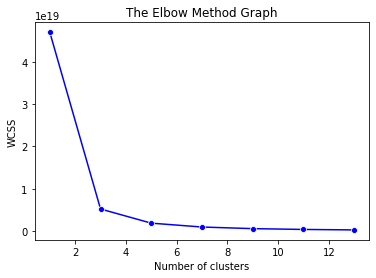

In [18]:
#Using Elbow graph to find optimum no. of Clusters
sns.lineplot(x=range(1, 14, 2), y=wcss, marker='o', color='blue')
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
# train model with k=5
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(train)

# predict clusters
y_kmeans = kmeans.predict(test)
y_kmeans

array([1, 1, 3, ..., 3, 3, 3])

In [22]:
# check the accuracy of the model
adjusted_rand_score(test['user_id'], y_kmeans)

5.1330017300278226e-05

In [30]:
# get the cluster centers
print(kmeans.cluster_centers_)
cluster_centers = kmeans.cluster_centers_
# get the cluster labels
print(kmeans.labels_)
cluster_labels = kmeans.labels_


[[9.06987747e+03 8.01041544e+05 6.51692512e-01]
 [9.07323803e+03 1.86682307e+06 6.51685873e-01]
 [9.06972607e+03 2.68666988e+05 6.50510840e-01]
 [9.07115056e+03 2.39095385e+06 6.50395589e-01]
 [9.07176350e+03 1.33563724e+06 6.51104056e-01]]
[3 1 1 ... 1 0 1]


In [33]:
# create a new dataframe with cluster labels
cluster_labels_df = pd.DataFrame(cluster_labels)
cluster_labels_df.columns = ['cluster_labels']
cluster_labels_df.head()

,cluster_labels
0,3
1,1
2,1
3,1
4,1


In [35]:
# add cluster labels to the test data
test.reset_index(inplace=True)
test.drop(['index'], axis=1, inplace=True)

test = pd.concat([test, cluster_labels_df], axis=1)
test.head()

,movie_id,user_id,rating,cluster_labels
0,7230.0,2058124.0,1.00,3
1,14550.0,1950710.0,1.00,1
2,13493.0,2216321.0,0.75,1
3,17189.0,1500388.0,1.00,1
4,13216.0,1725728.0,0.50,1


In [36]:
# model accuracy
test.groupby('cluster_labels')['rating'].mean()


cluster_labels
0    0.651259
1    0.650933
2    0.651038
3    0.651066
4    0.650919
Name: rating, dtype: float64

In [37]:
#import pickle library
import pickle
# dump the model
pickle.dump(kmeans, open('kmeans.pkl', 'wb'))


In [ ]:
# 

### We can also use different clustering tecniques such as:
<ol>
    <li>hierarichical clustering</li>
    <li>DBSCAN</li>
    <li>Guassian Model Mixture (GMM)</li>
    <li>Random Projection</li>
</ol>